In [77]:
#импортируем библиотеки
import pandas as pd
import tensorflow as tf
import numpy as np
from tensorflow.keras.utils import to_categorical 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import BatchNormalization,Activation,Dropout
from matplotlib import pyplot as plt
from datawig import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
plt.rcParams["figure.figsize"] = (9,9)

In [78]:
#загружаем данные
Data = pd.read_csv('WISDM_ar_v1.1_raw.txt', names= ["user-id", "activity", "timestamp", "x-axis", "y-axis", "z-axis"])
Data["z-axis"] = [float(str(Element).replace(";", "")) for Element in Data["z-axis"]]
Data.dropna(axis=0,inplace=True)
#Data = Data.iloc[np.random.permutation(len(Data))]

In [79]:
#переименуем столбец для удобства
Data.rename(columns={'user-id':'user'},inplace=True)

## Посмотрим на первых двух пользователей

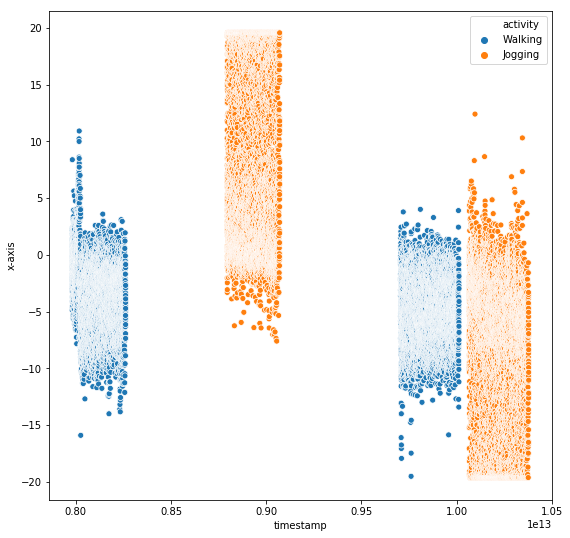

In [80]:
sns.scatterplot(x='timestamp',y='x-axis',hue='activity',data=Data[Data.user==2])
plt.show()

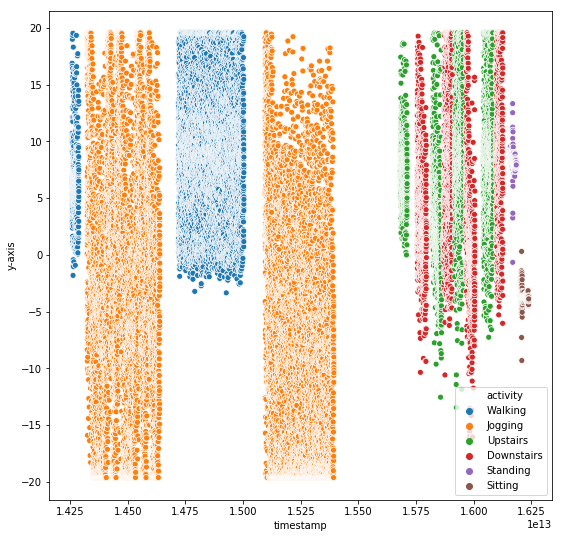

In [81]:
sns.scatterplot(x='timestamp',y='y-axis',hue='activity',data=Data[Data.user==24])
plt.show()

## Разделим данные на тест и тренировочные и произведем обучение на одном user=1


In [82]:
Data_1=Data[Data.user==1]
Data_1=shuffle(Data_1)
Y=Data_1.activity
Data_1.drop(columns=['activity'],axis=1,inplace=True)
X=Data_1
X_train1, X_test1, Y_train1, Y_test1 =train_test_split(X, Y, test_size=0.33, random_state=42)
Y_train_one=Y_train1
Y_train1=pd.get_dummies(Y_train1)
Y_test1=pd.get_dummies(Y_test1)

X_train1=X_train1.astype('float')
X_test1=X_test1.astype('float')
#Y_test1.size
Y_train1.head()
Y_test1.head()



,Downstairs,Jogging,Upstairs,Walking
959506,0,0,0,1
950800,0,1,0,0
945512,0,0,0,1
948990,0,1,0,0
954021,0,0,0,1


## Функция, создающая лес

In [83]:
def forest(k,X_train,Y_train,X_test,Y_test):
    forest_model = RandomForestRegressor(random_state=1)
    forest_model.fit(X_train.iloc[:k], Y_train.iloc[:k])
    melb_preds = forest_model.predict(X_test)
    return mean_absolute_error(Y_test, melb_preds)

## Не анализируя природу данных попробуем создать модель и обучить ее на тех признаках, которые мы имеем

In [84]:
print(forest(10000,X_train1,Y_train1,X_test1,Y_test1))


0.00026281208935611036


## Как видим, модель ведет себя очень странно, даже если бы она просто угадывала, то мы бы получили больший процент

## Рассмотрим еще один, предположительно более хороший метод обучения

In [85]:
Y_train_two=Y_train1.iloc[:,0]*4+Y_train1.iloc[:,1]*3+Y_train1.iloc[:,2]*2+Y_train1.iloc[:,3]*1
Y_test_two=Y_test1.iloc[:,0]*4+Y_test1.iloc[:,1]*3+Y_test1.iloc[:,2]*2+Y_test1.iloc[:,3]*1



In [86]:
from xgboost import XGBRegressor

my_model = XGBRegressor()
# Add silent=True to avoid printing out updates with each cycle
my_model.fit(X_train1, Y_train_two, verbose=False)
predictions = my_model.predict(X_test1)
print (predictions)

[1.0136743 2.961062  1.0088141 ... 1.0088141 3.9757926 3.9728825]


In [87]:
def accuracy(prediction, answer):
    i = 0.
    for x, y in zip(prediction, answer):
        if(int(x) == y):
            i += 1
    return i / (len(answer))

In [88]:
accuracy(predictions,Y_test_two)

0.5164257555847569

In [89]:
lst=list()
x=np.linspace(0,20000,20)
def xgbb(X_train1,X_test1,Y_train_two,Y_test_two):
    my_model = XGBRegressor()
    # Add silent=True to avoid printing out updates with each cycle
    my_model.fit(X_train1, Y_train_two, verbose=False)
    predictions = my_model.predict(X_test1)
    return accuracy(predictions,Y_test_two)



In [90]:

for i in np.linspace(2,20000,20):
    k=int(i)
    lst.append(xgbb(X_train1[:k],X_test1,Y_train_two[:k],Y_test_two))
print(lst)

[0.10431618315980996, 0.6751238249267159, 0.6405539270191044, 0.6328717274840796, 0.5133933083998787, 0.6040634792277367, 0.5148084504194885, 0.52016577377944, 0.66481350449813, 0.5170322450217325, 0.5170322450217325, 0.6017386030526635, 0.6038613160820783, 0.5992115637319316, 0.604164560800566, 0.6067926816941271, 0.6030526634994441, 0.5163246740119276, 0.5181441423228546, 0.5203679369250985]


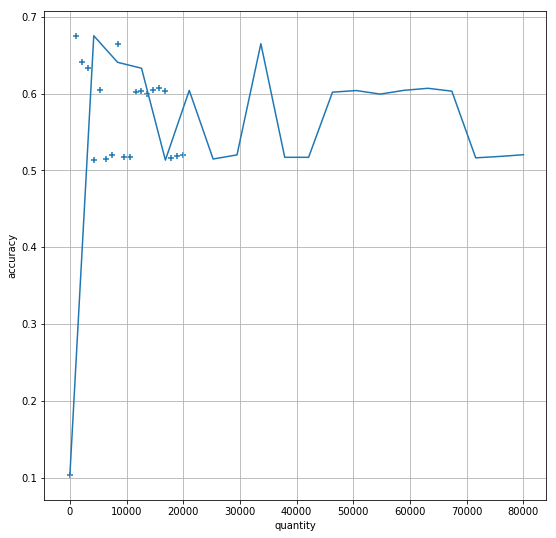

In [91]:
plt.plot(x1,lst)
plt.scatter(x,lst,marker='+')
plt.grid(True)
plt.xlabel("quantity")
plt.ylabel("accuracy")
plt.show()

## Ого, такая точность нас уже устраивает больше, но давайте попробуем все-таки разобраться в природе данных

In [92]:
d=Data[Data.user==1][Data.activity=='Jogging'].describe()
d

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,user,timestamp,x-axis,y-axis,z-axis
count,11056.0,1.105600e+04,11056.000000,11056.000000,11056.000000
mean,1.0,5.854319e+12,-0.208456,0.197931,1.164557
std,0.0,3.322621e+11,10.706282,9.483499,5.653878
min,1.0,5.374662e+12,-19.610000,-19.610000,-17.200000
25%,1.0,5.512840e+12,-7.080000,-6.430000,-2.530000
50%,1.0,6.022097e+12,-0.040000,0.420000,0.570000
75%,1.0,6.160305e+12,6.827500,6.400000,4.860000
max,1.0,6.298492e+12,19.570000,19.570000,19.000000


In [93]:
a=np.array([d.iloc[1,2] for i in range(0,len(Data[Data.user==1][Data.activity=='Jogging']))])
Data.dtypes
a.dtype

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


dtype('float64')

In [94]:
#d=Data[Data.user==][Data.activity==j]

In [96]:
Date=pd.DataFrame(columns=['mean_x','mean_y','mean_z','std_x','std_y','std_z'])

for i in range(1,2):
    for j in tuple(['Walking', 'Downstairs', 'Sitting', 'Upstairs', 'Jogging', 'Standing']):
        d=Data[Data.user==i][Data.activity==j]
        d1=Data[Data.user==i][Data.activity==j].describe()
        mean_x=np.array([d1.iloc[1,2] for i in range(0,len(d))])
        mean_y=np.array([d1.iloc[1,3] for i in range(0,len(d))])
        mean_z=np.array([d1.iloc[1,4] for i in range(0,len(d))])
        std_x=np.array([d1.iloc[2,2] for i in range(0,len(d))])
        std_y=np.array([d1.iloc[2,3] for i in range(0,len(d))])
        std_z=np.array([d1.iloc[2,4] for i in range(0,len(d))])
        dat=pd.DataFrame({'mean_x':mean_x,'mean_y':mean_y,'mean_z':mean_z})
        dat_std=pd.DataFrame({'std_x':std_x,'std_y':std_y,'std_z':std_z})
        
        #print(dat.head())
        #print(dat_std.head())
        do=dat.join(dat_std)
        Date=pd.concat([Date,do],axis=0)
        #print(Date.tail())
    
        


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipy

In [97]:
#print(Date.join(Data))
X_train2=Date[:20085]
X_test2=Date[20085:29978]


In [98]:
lst2=list()
for i in np.linspace(2,20000,20):
    k=int(i)
    lst2.append(xgbb(X_train2[:k],X_test2,Y_train_two[:k],Y_test_two))
print(lst2)

[0.425452340038411, 0.10431618315980996, 0.10431618315980996, 0.10431618315980996, 0.10431618315980996, 0.10431618315980996, 0.10431618315980996, 0.10431618315980996, 0.10431618315980996, 0.10431618315980996, 0.10431618315980996, 0.10431618315980996, 0.10431618315980996, 0.10431618315980996, 0.10431618315980996, 0.10431618315980996, 0.10431618315980996, 0.10431618315980996, 0.10431618315980996, 0.10431618315980996]


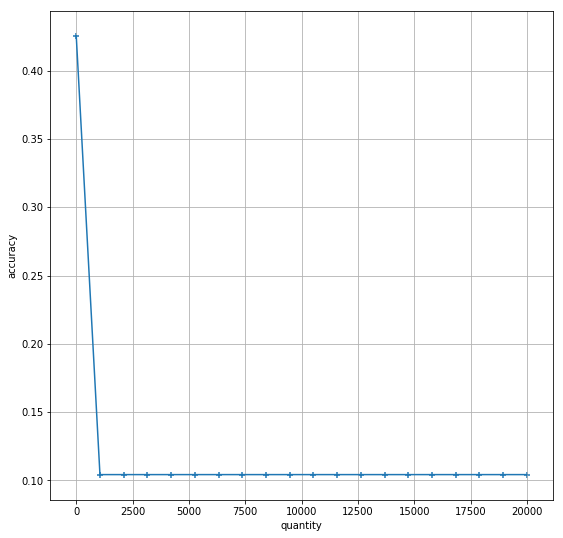

In [99]:
x2=np.linspace(2,20000,20)
plt.plot(x2,lst2)
plt.scatter(x2,lst2,marker='+')
plt.grid(True)
plt.xlabel("quantity")
plt.ylabel("accuracy")
plt.show()

## Нам не удалось расширить признаки так, чтобы повысить точность. Выглядит подозрительным, что accracy=сonst. Может быть это работает не так, как должно работать